In [1]:
import pandas as pd
import numpy as np
import collections
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud
from gensim.models import word2vec
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from matplotlib import pyplot
from scipy import spatial
from sklearn.manifold import TSNE
from sklearn.manifold import LocallyLinearEmbedding


ModuleNotFoundError: No module named 'wordcloud'

In [3]:
ingredients_df = pd.read_csv('ingredients.csv', sep=";")
recipes_df = pd.read_csv('recipes.csv',sep=";")
print(ingredients_df.shape)
print(recipes_df.shape)

(1035, 5)
(115, 12)


In [4]:
ingredients_df.head()

,uuid,quantity,unit,name,category
0,666995576ae7c8be50c7,800,g,oat bread,Bakery
1,b1997b662d682300b081,2,tbsp,gelatin,Bakery
2,a5ad2b18ce6a8cf1137f,18,tbsp,biscuits,Bakery
3,b3802daafb8b2121e09b,200,g,biscuits,Bakery
4,f17672605ba58e226ff9,1,tbsp,baking powder,Bakery


In [5]:
recipes_df.head()

,uuid,global_rating,number_of_ratings,name,steps,meal_type,origin,prep_time,servings,description,difficulty,photo_url
0,24d25b308700d23f709b,5,32,Butternut squash soup with chilli & crème fraîche,Heat oven to 200C/180C fan/gas 6.Cut 1 peeled ...,starter,English,65,4,Come in from the cold to a warming bowlful of ...,Easy,www.bbcgoodfood.com/sites/default/files/styles...
1,8b1fcfc80c7231df0d48,5,278,Moroccan chickpea soup,"Heat the oil in a large saucepan, then fry the...",starter,Middle East,25,4,Try something different for vegetarians with M...,Easy,www.bbcgoodfood.com/sites/default/files/styles...
2,74195811e951e9fbe3f8,5,276,Broccoli & stilton soup,Heat 2 tbsp rapeseed oil in a large saucepan a...,starter,English,45,4,A smooth blended vegetable soup with blue chee...,Easy,www.bbcgoodfood.com/sites/default/files/styles...
3,f72acec0c134474aa129,5,215,Mushroom risotto,Put 50g dried porcini mushrooms into a large b...,starter,Italian,30,4,Barney guides you through a step-by-step guide...,Easy,www.bbcgoodfood.com/sites/default/files/styles...
4,2346df08e1939e37ed64,5,211,Spicy roasted parsnip soup,"Heat oven to 220C/fan 200C/gas 7.In a bowl, mi...",starter,British,45,4,Aromatic flavours transform the ordinary parsn...,Easy,www.bbcgoodfood.com/sites/default/files/styles...


In [6]:
ingredients_by_recipe = ingredients_df[["uuid", "name"]].groupby(['uuid']).agg({'name':lambda x: list(x)})
ingredients_by_recipe["ingredient_category_list"] = ingredients_df[["uuid", "category"]].groupby(['uuid']).agg({'category': lambda y: list(y)})
ingredients_by_recipe["num_of_ingredients"] = ingredients_df[["uuid", "name"]].groupby(['uuid']).size()
ingredients_by_recipe.columns = ["ingredient_list","ingredient_category_list","num_of_ingredients"]
ingredients_by_recipe

,ingredient_list,ingredient_category_list,num_of_ingredients
uuid,,,
02f1939873c5ed70986c,"[red wine, olive oil, butter, cheddar, lentils...","[Beverage Alcoholic, Condiment, Dairy, Dairy, ...",11
0412d199f71146f42257,"[butter, cheddar, milk, yogurt, flour, peas, b...","[Dairy, Dairy, Dairy, Dairy, Dry, Dry, Vegetab...",12
0528174c0168ac50d4d4,"[tomato sauce, olive oil, butter, cheddar, mil...","[Canned Goods, Condiment, Dairy, Dairy, Dairy,...",16
0992b75fd5a8cc6a3e3e,"[butter, cream, flour, bay leaf, garlic, parsl...","[Dairy, Dairy, Dry, Herb and Spice, Herb and S...",9
09b214104c84283f8cb2,"[sugar, lemon juice, olive oil, parmesan, spag...","[Bakery, Beverage, Condiment, Dairy, Dry, Herb...",7
...,...,...,...
f5a8b956994f4a68f90c,"[olive oil, pepper, garlic, rosemary, beef, to...","[Condiment, Condiment, Herb and Spice, Herb an...",8
f72acec0c134474aa129,"[white wine, olive oil, butter, parmesan, riso...","[Beverage Alcoholic, Condiment, Dairy, Dairy, ...",11
fbd0c5b8660e5b1815d9,"[caster sugar, red wine, white wine, melon, ra...","[Bakery, Beverage Alcoholic, Beverage Alcoholi...",10


In [7]:
recipes_df_joined = pd.merge(recipes_df, ingredients_by_recipe, on='uuid')
print(recipes_df_joined.shape)

(115, 15)


In [8]:
recipes_df_joined

,uuid,global_rating,number_of_ratings,name,steps,meal_type,origin,prep_time,servings,description,difficulty,photo_url,ingredient_list,ingredient_category_list,num_of_ingredients
0,24d25b308700d23f709b,5,32,Butternut squash soup with chilli & crème fraîche,Heat oven to 200C/180C fan/gas 6.Cut 1 peeled ...,starter,English,65,4,Come in from the cold to a warming bowlful of ...,Easy,www.bbcgoodfood.com/sites/default/files/styles...,"[olive oil, butter, creme fraiche, butternut s...","[Condiment, Dairy, Dairy, Fruit, Herb and Spic...",8
1,8b1fcfc80c7231df0d48,5,278,Moroccan chickpea soup,"Heat the oil in a large saucepan, then fry the...",starter,Middle East,25,4,Try something different for vegetarians with M...,Easy,www.bbcgoodfood.com/sites/default/files/styles...,"[olive oil, beans, chickpea, lemon, celery, co...","[Condiment, Dry, Dry, Fruit, Herb and Spice, H...",10
2,74195811e951e9fbe3f8,5,276,Broccoli & stilton soup,Heat 2 tbsp rapeseed oil in a large saucepan a...,starter,English,45,4,A smooth blended vegetable soup with blue chee...,Easy,www.bbcgoodfood.com/sites/default/files/styles...,"[sunflower oil, butter, stilton, celery, brocc...","[Condiment, Dairy, Dairy, Herb and Spice, Vege...",9
3,f72acec0c134474aa129,5,215,Mushroom risotto,Put 50g dried porcini mushrooms into a large b...,starter,Italian,30,4,Barney guides you through a step-by-step guide...,Easy,www.bbcgoodfood.com/sites/default/files/styles...,"[white wine, olive oil, butter, parmesan, riso...","[Beverage Alcoholic, Condiment, Dairy, Dairy, ...",11
4,2346df08e1939e37ed64,5,211,Spicy roasted parsnip soup,"Heat oven to 220C/fan 200C/gas 7.In a bowl, mi...",starter,British,45,4,Aromatic flavours transform the ordinary parsn...,Easy,www.bbcgoodfood.com/sites/default/files/styles...,"[olive oil, lemon, coriander, cumin, garlic, g...","[Condiment, Fruit, Herb and Spice, Herb and Sp...",11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,433d924a6eb8706b5ba1,5,1,Strawberry & mint granita,Put the sugar and 100ml water in a medium sauc...,dessert,Italian,20,4,This light frozen dessert is smooth and slushy...,Easy,www.bbcgoodfood.com/sites/default/files/styles...,"[caster sugar, strawberry, mint]","[Bakery, Fruit, Herb and Spice]",3
111,db57f1743fa154618cd2,4,12,Panettone,Grease a panettone tin (see Tip) or a 20cm dee...,dessert,Italian,70,6,Prove your baking skills this Christmas with a...,Hard,www.bbcgoodfood.com/sites/default/files/styles...,"[caster sugar, bread, caster sugar, icing suga...","[Bakery, Bakery, Bakery, Bakery, Beverage Alco...",17
112,837b068723364c202aff,5,16,Zabaglione trifle slice,"For the zabaglione cream, put the egg yolks an...",dessert,Italian,90,8,"This dish is inspired by trifle and tiramisu, ...",Hard,www.bbcgoodfood.com/sites/default/files/styles...,"[caster sugar, marsala wine, marsala wine, whi...","[Bakery, Beverage Alcoholic, Beverage Alcoholi...",8
113,0dda049dc7ae42af6c05,5,9,Toasted marshmallow & ginger cake,"Melt the butter, sugar, treacle and syrup in a...",dessert,Italian,130,8,"Decorative Italian meringue masks a spicy, moi...",Hard,www.bbcgoodfood.com/sites/default/files/styles...,"[light brown sugar, caster sugar, golden syrup...","[Bakery, Bakery, Bakery, Bakery, Beverage Alco...",16


In [9]:
#collections.Counter(ingredients_df["name"])

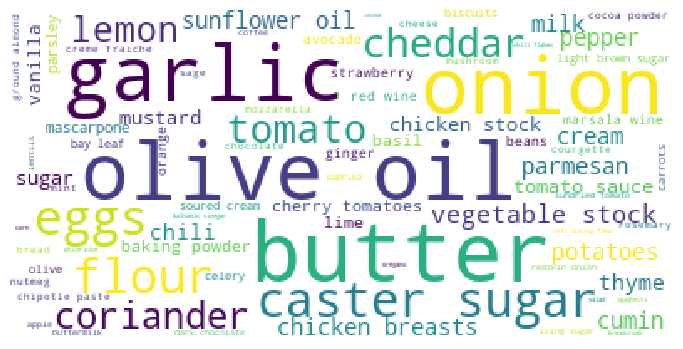

In [10]:
fr=pd.Series(ingredients_df["name"]).value_counts()
wordcloud = WordCloud(background_color="white",max_words=80,random_state=21, max_font_size=50, collocations=False).generate_from_frequencies(fr)
fig=plt.figure(figsize=(12,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [11]:
nb_of_recipes = recipes_df_joined.shape[0]
list_of_ingredients = list()
for i in range(nb_of_recipes):
    list_of_ingredients.append(list(set(recipes_df_joined.iloc[i,-3]))) #to add unique list of ingredients

In [57]:
model = Word2Vec.load("word2vec.model")

In [58]:
model = Word2Vec(min_count=0,
                     window=10,
                     size=20,
                     sample=6e-5, 
                     alpha=0.3, 
                     min_alpha=0.0007,
                     workers=4,
                    sg = 1)

model.build_vocab(list_of_ingredients, progress_per=10)
model.train(list_of_ingredients, total_examples=model.corpus_count, epochs=500, report_delay=1)
model.init_sims(replace=True)
model.save("word2vec.model")
print(model.wv.most_similar('chocolate'))

[('coffee', 0.9255062341690063), ('marsala wine', 0.8904293775558472), ('dark chocolate', 0.8886752128601074), ('cocoa powder', 0.8884561061859131), ('brandy', 0.8645170331001282), ('cocoa', 0.8482412099838257), ('hazelnut', 0.8388174772262573), ('sponge finger', 0.8340359330177307), ('golden syrup sugar', 0.801234245300293), ('gelatin', 0.7859083414077759)]


In [59]:
print(model.wv.most_similar('chicken legs'))

[('mushroom', 0.8569544553756714), ('red wine', 0.8448411822319031), ('risotto rice', 0.8061820268630981), ('sausage', 0.7257565259933472), ('chestnut', 0.7104321718215942), ('carrots', 0.6924177408218384), ('parsley', 0.6919506788253784), ('fennel', 0.6760588884353638), ('pasta', 0.6727045774459839), ('sweet potato', 0.6371208429336548)]


In [61]:
print(model.wv.similarity('chicken legs','chocolate'))


0.21467912


In [117]:
print(model.wv.similarity('coriander','cumin'))


0.73393095


In [41]:
# ingredient_vector_dim = 20
# max_distance_ingredient = 12 # max ingredient distance to consider in a sentence 
# min_count = 0 #minimum total frequency for an ingredient
# model = Word2Vec(list_of_ingredients, size=20, window=10, min_count=1, workers=4, sg = 1, seed = 1)
# model.init_sims(replace=True)

# print(model.wv.most_similar('chocolate'))


[('curry paste', 0.6504259705543518), ('broccoli', 0.6018439531326294), ('chickpea', 0.5996891260147095), ('pasta', 0.5818215012550354), ('sweet potato', 0.5530897974967957), ('coffee', 0.5392258763313293), ('tomato paste', 0.5250109434127808), ('ginger', 0.516396164894104), ('bread', 0.4921433627605438), ('mayonnaise', 0.48885971307754517)]


In [13]:
# list(model.wv.vocab)

['butter',
 'creme fraiche',
 'olive oil',
 'garlic',
 'onion',
 'chili',
 'vegetable stock',
 'butternut squash',
 'chickpea',
 'celery',
 'tomato',
 'coriander',
 'lemon',
 'cumin',
 'beans',
 'stilton',
 'potatoes',
 'sunflower oil',
 'broccoli',
 'leek',
 'risotto rice',
 'mushroom',
 'parmesan',
 'white wine',
 'parsley',
 'ground turmeric',
 'parsnip',
 'mustard',
 'pumpkin seeds',
 'cream',
 'salad',
 'smoked salmon',
 'ginger',
 'prawns',
 'lime',
 'honey',
 'smoked mackerel',
 'flour',
 'eggs',
 'cabbage',
 'tomato sauce',
 'spaghetti',
 'carrots',
 'mint',
 'sugar',
 'chili flakes',
 'shallot',
 'caster sugar',
 'fish sauce',
 'rice vinegar',
 'cucumber',
 'peanuts',
 'avocado',
 'chicken stock',
 'bay leaf',
 'brioche',
 'chicken livers',
 'apple',
 'thyme',
 'pepper',
 'crayfish tails',
 'chicory',
 'cheese',
 'pasta',
 'cajun spices',
 'chorizo',
 'rice',
 'chicken breasts',
 'curry paste',
 'lentils',
 'yogurt',
 'basil',
 'pesto',
 'cherry tomatoes',
 'ground coriander',

In [124]:
#function for annotated plot

def annotated_plot(result,title):
    plt.scatter(result[:, 0], result[:, 1], color='orange')
    words = list(model.wv.vocab)
    for i, word in enumerate(words):
        plt.annotate(word, xy=(result[i, 0], result[i, 1]), size=7, weight='light')
    plt.title(title)
    plt.xlabel("1st component")
    plt.ylabel("2nd component")
    plt.show()
    
    

In [128]:
#function for plot mapped by category

def mapping_by_category_plot(result, title):
    words = list(model.wv.vocab)
    categories = list()
    for word in words:
        category = np.array(ingredients_df.loc[ingredients_df["name"] == word]["category"])[0]
        categories.append(category)

    df = pd.DataFrame({"x": result[:,0],
                      "y": result[:,1],
                      "category": categories
                      })

    groups = df.groupby("category")
    for name, group in groups:
        plt.plot(
        group["x"],
        group["y"],
        marker="o",
        linestyle="",
        label=name)

    plt.title(title)
    plt.xlabel("1st component")
    plt.ylabel("2nd component")
    plt.legend(bbox_to_anchor=(1, 1))
    plt.show()

In [118]:
count_cuis = collections.Counter(recipes_df_joined["origin"])
count_ing = collections.Counter(ingredients_df["name"])
track_ingredients = dict(zip(count_cuis.keys(), [list() for x in count_cuis.keys()]))

for i in range(recipes_df_joined.shape[0]):
    ingredients = recipes_df_joined.iloc[i,-3]
    track_ingredients[recipes_df_joined.iloc[i,6]].extend(ingredients)
    
for label, tracking in track_ingredients.items():
    track_ingredients[label] = collections.Counter(tracking)
    
def return_most_popular(ing):
    origin = None
    record = 0
    for label, tracking in track_ingredients.items():
        norm_freq = float(tracking[ing]) / float(count_ing[ing])
        if norm_freq > record:
            origin = label
            record = norm_freq
            
    return origin

In [131]:
#function for plot mapped by most frequent origin per ingredient

def mapping_by_origin_plot(result, title):
    
    words = list(model.wv.vocab)
    origins = list()
    for word in words:
        origin = return_most_popular(word)
        origins.append(origin)

    df = pd.DataFrame({"x": result[:,0],
                      "y": result[:,1],
                      "origin": origins
                      })

    groups = df.groupby("origin")
    for name, group in groups:
        plt.plot(
        group["x"],
        group["y"],
        marker="o",
        linestyle="",
        label=name)

    # plt.scatter(result[:, 0], result[:, 1], color=categories)
    plt.title(title)
    plt.xlabel("1st component")
    plt.ylabel("2nd component")
    plt.legend(bbox_to_anchor=(1, 1))
    plt.show()

### PCA

In [135]:
X = model.wv[model.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)


In [153]:
pca.explained_variance_ratio_

array([0.1366821 , 0.10849795], dtype=float32)

In [67]:
pca = PCA()
pca.fit(X)
cumsum = np.cumsum(pca.explained_variance_ratio_)
np.argmax(cumsum >= 0.95) +1
cumsum

array([0.1366821 , 0.24518004, 0.3421809 , 0.42389208, 0.50294435,
       0.57004166, 0.63231885, 0.68444264, 0.7337481 , 0.7784524 ,
       0.82144773, 0.8608073 , 0.893745  , 0.92065257, 0.94274646,
       0.96301734, 0.97724277, 0.9894191 , 0.99808705, 0.9999998 ],
      dtype=float32)

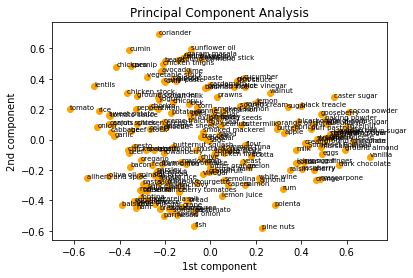

In [136]:
annotated_plot(result, "Principal Component Analysis")

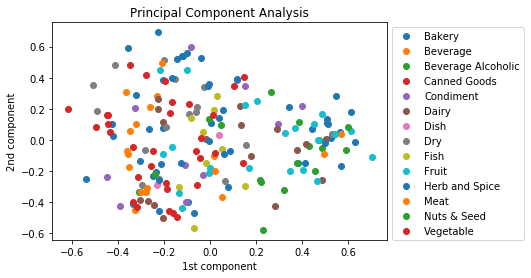

In [137]:
mapping_by_category_plot(result, "Principal Component Analysis")

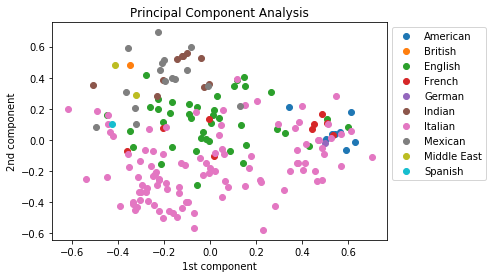

In [138]:
mapping_by_origin_plot(result, "Principal Component Analysis")

### LLE

In [140]:
X = model.wv[model.wv.vocab]
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=15)
result= lle.fit_transform(X)

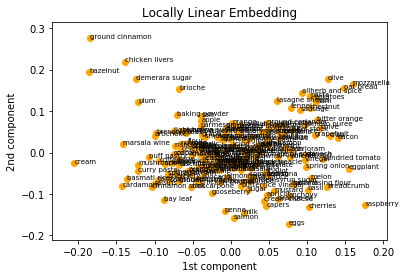

In [141]:
annotated_plot(result, "Locally Linear Embedding")

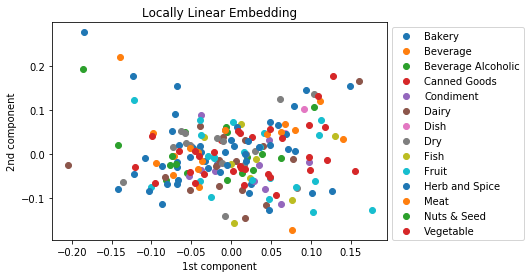

In [142]:
mapping_by_category_plot(result, "Locally Linear Embedding")

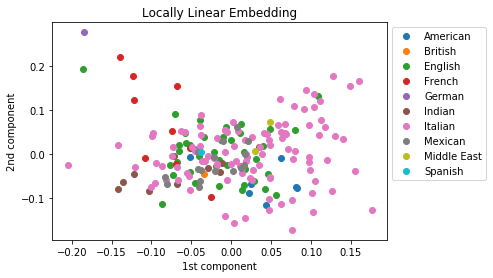

In [143]:
mapping_by_origin_plot(result, "Locally Linear Embedding")

### TSNE

In [149]:
X = model.wv[model.wv.vocab]
tsne = TSNE(n_components=2)
result= tsne.fit_transform(X)

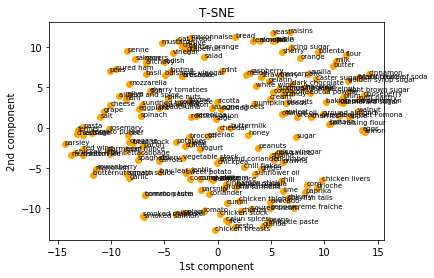

In [150]:
annotated_plot(result, "T-SNE")

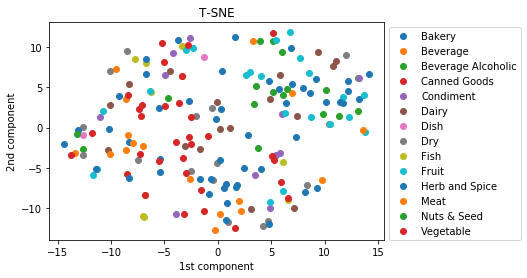

In [151]:
mapping_by_category_plot(result, "T-SNE")

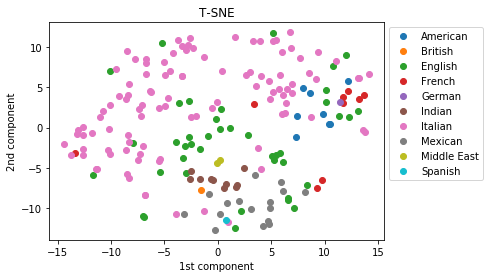

In [152]:
mapping_by_origin_plot(result, "T-SNE")

### Recommendation

In [155]:
index2word_set = set(model.wv.index2word)

def avg_feature_vector(recipe_array, model, num_features, index2word_set):
    ingredients = list(set(recipe_array))
    feature_vec = np.zeros((num_features, ), dtype='float32')
    n_ingredients = 0
    for ingredient in ingredients:
        if ingredient in index2word_set:
            n_ingredients += 1
            feature_vec = np.add(feature_vec, model.wv[ingredient])
    if (n_ingredients > 0):
        feature_vec = np.divide(feature_vec, n_ingredients)
    return feature_vec

In [157]:
#similarity score between first 2 recipes

r1_afv = avg_feature_vector(list_of_ingredients[0], model=model, num_features=20, index2word_set=index2word_set)
r2_afv = avg_feature_vector(list_of_ingredients[1], model=model, num_features=20, index2word_set=index2word_set)

sim = 1 - spatial.distance.cosine(r1_afv, r2_afv)

print(sim)

0.8521614074707031


array([-0.16854095, -0.03542717,  0.05432731, -0.00352334, -0.15876667,
       -0.18570206,  0.07446416,  0.08793643,  0.10369013, -0.13655525,
       -0.1288377 , -0.22881117, -0.1731318 , -0.06908469,  0.04094486,
       -0.18548875,  0.00596008, -0.14698674,  0.34444612,  0.03957787],
      dtype=float32)

In [82]:
#best recommendation for the 1st recipe

afv_list = list()
for i in range(len(list_of_ingredients)):
    afv = avg_feature_vector(list_of_ingredients[i], model=model, num_features=20, index2word_set=index2word_set)
    afv_list.append(afv)
    
similarity_score = list()
for i in range(len(list_of_ingredients)):
    sim = 1 - spatial.distance.cosine(afv_list[0], afv_list[i])
    similarity_score.append(sim)

index = np.argsort(similarity_score)[-2]
print(list_of_ingredients[index], list_of_ingredients[0])

['paprika', 'potatoes', 'pepper', 'olive oil', 'soured cream', 'garlic', 'onion', 'chili', 'cumin'] ['butter', 'creme fraiche', 'olive oil', 'garlic', 'onion', 'chili', 'vegetable stock', 'butternut squash']


In [161]:
def recommended_recipe(ingredients_for_one_recipe, ingredients_for_all_recipes):

    afv_list = list()
    similarity_score = list()
    afv_recipe = avg_feature_vector(ingredients_for_one_recipe, model=model, num_features=20, index2word_set=index2word_set)
    
    for i in range(len(ingredients_for_all_recipes)):
        afv = avg_feature_vector(ingredients_for_all_recipes[i], model=model, num_features=20, index2word_set=index2word_set)
        afv_list.append(afv)
        sim = 1 - spatial.distance.cosine(afv_recipe, afv_list[i])
        similarity_score.append(sim)

    index = np.argsort(similarity_score)[-2]
    return list_of_ingredients[index], index

In [2]:
recipes_df_joined[["name"]] == "Mushroom soup"

NameError: name 'recipes_df_joined' is not defined

In [162]:
def recommender(index_recipe):
    index = index_recipe
    ingredients_recipe = list_of_ingredients[index]
    ingredients_reco, index_new = recommended_recipe(ingredients_recipe, list_of_ingredients)
    recipe = recipes_df_joined.iloc[index,3]
    reco = recipes_df_joined.iloc[index_new,3]
    print("current recipe:", recipe)
    print("current ingredients:", ingredients_recipe)
    print("                   ")
    print("recommended recipe:", reco)
    print("recommended ingredients:", ingredients_reco)
    return reco


In [163]:
recommender(11)

current recipe: Mushroom soup
current ingredients: ['butter', 'chicken stock', 'flour', 'mushroom', 'bay leaf', 'garlic', 'onion', 'cream', 'parsley']
                   
recommended recipe: Mushroom risotto
recommended ingredients: ['butter', 'risotto rice', 'mushroom', 'olive oil', 'garlic', 'onion', 'parmesan', 'white wine', 'parsley', 'vegetable stock']


'Mushroom risotto'

In [164]:
recommender(88)

current recipe: Italian toasties
current ingredients: ['ham', 'oat bread', 'olive', 'olive oil', 'mozzarella', 'onion', 'sundried tomato', 'cheese']
                   
recommended recipe: Italian stuffed chicken
recommended ingredients: ['olive', 'olive oil', 'allherb and spice', 'garlic', 'cheese', 'tomato']


'Italian stuffed chicken'

In [165]:
recommender(106)

current recipe: Torta del Nonna
current ingredients: ['butter', 'orange', 'dark chocolate', 'flour', 'caster sugar', 'vanilla', 'milk', 'eggs', 'pine nuts', 'icing sugar', 'ricotta']
                   
recommended recipe: Orange polenta cake
recommended ingredients: ['butter', 'orange', 'flour', 'baking powder', 'polenta', 'caster sugar', 'eggs']


'Orange polenta cake'

In [166]:
recipes_df_joined.loc[recipes_df_joined["name"] == reco]["uuid"]

41    992b01ee1b5c69845eec
Name: uuid, dtype: object

In [6]:
import pandas as pd
import numpy as np
import collections
# from gensim.models import word2vec
from gensim.models import Word2Vec
from scipy import spatial

ingredients_df = pd.read_csv('/home/louis/code/gatinetlouis/KROK-Follow-Up/db/datas/ingredients.csv', sep=";")
recipes_df = pd.read_csv('/home/louis/code/gatinetlouis/KROK-Follow-Up/db/datas/recipes_new.csv',sep=";")
ingredients_by_recipe = ingredients_df[["uuid", "name"]].groupby(['uuid']).agg({'name':lambda x: list(x)})
ingredients_by_recipe["ingredient_category_list"] = ingredients_df[["uuid", "category"]].groupby(['uuid']).agg({'category': lambda y: list(y)})
ingredients_by_recipe["num_of_ingredients"] = ingredients_df[["uuid", "name"]].groupby(['uuid']).size()
ingredients_by_recipe.columns = ["ingredient_list","ingredient_category_list","num_of_ingredients"]
recipes_df_joined = pd.merge(recipes_df, ingredients_by_recipe, on='uuid')
nb_of_recipes = recipes_df_joined.shape[0]
list_of_ingredients = list()
for i in range(nb_of_recipes):
    list_of_ingredients.append(list(set(recipes_df_joined.iloc[i,-3]))) #to add unique list of ingredients
# model = Word2Vec.load("word2vec.model")
model = Word2Vec(min_count=0,
                     window=10,
                     size=20,
                     sample=6e-5,
                     alpha=0.3,
                     min_alpha=0.0007,
                     workers=4,
                    sg = 1)

model.build_vocab(list_of_ingredients, progress_per=10)
model.train(list_of_ingredients, total_examples=model.corpus_count, epochs=500, report_delay=1)
model.init_sims(replace=True)
# model.save("word2vec.model")
# print(model.wv.most_similar('chocolate'))
# print(list_of_ingredients)
# print(ingredients_df.shape)
# print(recipes_df.shape)
index2word_set = set(model.wv.index2word)

def avg_feature_vector(recipe_array, model, num_features, index2word_set):
    ingredients = list(set(recipe_array))
    feature_vec = np.zeros((num_features, ), dtype='float32')
    n_ingredients = 0
    for ingredient in ingredients:
        if ingredient in index2word_set:
            n_ingredients += 1
            feature_vec = np.add(feature_vec, model.wv[ingredient])
    if (n_ingredients > 0):
        feature_vec = np.divide(feature_vec, n_ingredients)
    return feature_vec

def recommended_recipe(ingredients_for_one_recipe, ingredients_for_all_recipes):

    afv_list = list()
    similarity_score = list()
    afv_recipe = avg_feature_vector(ingredients_for_one_recipe, model=model, num_features=20, index2word_set=index2word_set)

    for i in range(len(ingredients_for_all_recipes)):
        afv = avg_feature_vector(ingredients_for_all_recipes[i], model=model, num_features=20, index2word_set=index2word_set)
        afv_list.append(afv)
        sim = 1 - spatial.distance.cosine(afv_recipe, afv_list[i])
        similarity_score.append(sim)

    index = np.argsort(similarity_score)[-2]
    return list_of_ingredients[index], index

def recommender(index_recipe):
    index = index_recipe
    ingredients_recipe = list_of_ingredients[index]
    ingredients_reco, index_new = recommended_recipe(ingredients_recipe, list_of_ingredients)
    recipe = recipes_df_joined.iloc[index,3]
    reco = recipes_df_joined.iloc[index_new,3]
    print("current recipe:", recipe)
    print("current ingredients:", ingredients_recipe)
    print("                   ")
    print("recommended recipe:", reco)
    print("recommended ingredients:", ingredients_reco)
    return reco

In [53]:
def find_index_with_recipe_name(recipe_name):
    true_false = recipes_df_joined[["name"]] == recipe_name
    index = np.where(true_false)[0][0]
    return index

In [54]:
find_index_with_recipe_name("Mushroom soup")

11

In [40]:
true_false["index"] = true_false.index
true_false.iloc[11,0]

True

11